# Dataset Exploration — Step 1: Understanding the Raw Data

**Goal:**  
This notebook analyzes the *raw histopathology dataset* provided for training and testing.  
We inspect file organization, patient counts, image formats (`.svs`, `.tif`), annotation structure (`.xml`), and metadata consistency between magnifications.

---

### Key Questions
1. How many patients are in the dataset?
2. What types of image files exist (`.svs`, `.tif`, `.xml`)?
3. Are dimensions consistent between `.svs` and `.tif`?
4. What is the typical resolution and size distribution of images?
5. What are the typical nucleus polygon areas and per-class area distributions?

---

### Table of Contents
- [Step 1 — Inspect Dataset Archives](#step1)
- [Step 2 — Explore File Types Inside the Archives](#step2)
- [Step 3 — Collect Patient and Image Metadata](#step3)
- [Step 4 — Visualize Image Dimensions](#step4)
- [Step 5 — Validate .svs ↔ .tif Consistency](#step5)
- [Step 6 — Polygon Area Distribution](#step6)
- [Step 7 — Polygon Areas by Cell Type](#step7)
- [Summary](#summary)




<a id="step1"></a>
## Step 1 — Inspect Dataset Archives


In [1]:
from pathlib import Path
import os
import zipfile
import pandas as pd
from openslide import OpenSlide

# === Paths ===
DATASETS_DIR = Path("/projectnb/ec500kb/projects/Fall_2025_Projects/Project_2/AI-guided-whole-slide-imaging-analysis/Datasets/BU_course_data")

TRAIN_ZIP = DATASETS_DIR / "TrainingData.zip"
TEST_ZIP  = DATASETS_DIR / "TestingData.zip"

# Unzipped directories (if already extracted)
TRAIN_DIR = DATASETS_DIR / "TrainingData" / "TrainingImages_and_Annotations"
TEST_DIR  = DATASETS_DIR / "TestingData"  / "TestingImages_and_Annotations"

for p in [TRAIN_ZIP, TEST_ZIP]:
    print("Exists:", p.exists(), p.name)


Exists: True TrainingData.zip
Exists: True TestingData.zip


In [2]:
!unzip -l /projectnb/ec500kb/projects/Fall_2025_Projects/Project_2/AI-guided-whole-slide-imaging-analysis/Datasets/BU_course_data/TrainingData.zip | head -20

Archive:  /projectnb/ec500kb/projects/Fall_2025_Projects/Project_2/AI-guided-whole-slide-imaging-analysis/Datasets/BU_course_data/TrainingData.zip
  Length      Date    Time    Name
---------  ---------- -----   ----
        0  09-18-2025 16:27   TrainingData/
        0  09-18-2025 16:03   TrainingData/TrainingImages_and_Annotations/
        0  09-18-2025 16:03   TrainingData/TrainingImages_and_Annotations/TCGA-55-1594-01Z-00-DX1/
  2337213  09-18-2025 16:03   TrainingData/TrainingImages_and_Annotations/TCGA-55-1594-01Z-00-DX1/TCGA-55-1594-01Z-00-DX1_001.svs
  3070138  09-18-2025 16:03   TrainingData/TrainingImages_and_Annotations/TCGA-55-1594-01Z-00-DX1/TCGA-55-1594-01Z-00-DX1_001.tif
   954158  09-18-2025 16:03   TrainingData/TrainingImages_and_Annotations/TCGA-55-1594-01Z-00-DX1/TCGA-55-1594-01Z-00-DX1_001.xml
  1002407  09-18-2025 16:03   TrainingData/TrainingImages_and_Annotations/TCGA-55-1594-01Z-00-DX1/TCGA-55-1594-01Z-00-DX1_002.svs
   782414  09-18-2025 16:03   TrainingData/Tr

In [3]:
!unzip -l /projectnb/ec500kb/projects/Fall_2025_Projects/Project_2/AI-guided-whole-slide-imaging-analysis/Datasets/BU_course_data/TestingData.zip | head -20

Archive:  /projectnb/ec500kb/projects/Fall_2025_Projects/Project_2/AI-guided-whole-slide-imaging-analysis/Datasets/BU_course_data/TestingData.zip
  Length      Date    Time    Name
---------  ---------- -----   ----
        0  09-18-2025 16:43   TestingData/
        0  09-18-2025 16:52   TestingData/TestingData/
        0  09-18-2025 16:50   TestingData/TestingData/TCGA-55-7570-01Z-00-DX1/
  1038865  09-18-2025 16:02   TestingData/TestingData/TCGA-55-7570-01Z-00-DX1/TCGA-55-7570-01Z-00-DX1_001.svs
   875032  09-18-2025 16:02   TestingData/TestingData/TCGA-55-7570-01Z-00-DX1/TCGA-55-7570-01Z-00-DX1_001.tif
   552233  09-18-2025 16:02   TestingData/TestingData/TCGA-55-7570-01Z-00-DX1/TCGA-55-7570-01Z-00-DX1_002.svs
    93578  09-18-2025 16:02   TestingData/TestingData/TCGA-55-7570-01Z-00-DX1/TCGA-55-7570-01Z-00-DX1_002.tif
        0  09-18-2025 16:02   TestingData/TestingData/TCGA-78-7152-01Z-00-DX1/
   786761  09-18-2025 16:02   TestingData/TestingData/TCGA-78-7152-01Z-00-DX1/TCGA-78-71

##### ..._001.svs   → original microscopy file (Openslide to read)
##### ..._001.tif   → same image exported from .svs (for convenience)
##### ..._001.xml   → annotation polygons (cell boundaries + labels)

<a id="step2"></a>
## Step 2 — Explore File Types Inside the Archives


In [4]:
from zipfile import ZipFile
from collections import Counter

def inspect_zip(zip_path, max_preview=20):
    """
    Inspect a zip file: list internal files, count by extension,
    and preview the first few lines of its directory tree.
    """
    if not zip_path.exists():
        print(f"❌ Zip not found: {zip_path}")
        return None, None
    
    with ZipFile(zip_path, 'r') as zf:
        files = zf.namelist()
    
    print(f"\n🧭 {zip_path.name}: {len(files)} total files")
    
    # Count file extensions
    exts = Counter([Path(f).suffix.lower() for f in files if not f.endswith("/")])
    df = pd.DataFrame({"ext": list(exts.keys()), "count": list(exts.values())}).sort_values("count", ascending=False)
    
    print("\nTop file types:")
    display(df)
    
    print("\nPreview of internal structure:")
    for f in files[:max_preview]:
        print(" ", f)
    
    return files, df

train_files, train_summary = inspect_zip(TRAIN_ZIP)
test_files,  test_summary  = inspect_zip(TEST_ZIP)



🧭 TrainingData.zip: 675 total files

Top file types:


,ext,count
0,.svs,209
1,.tif,209
2,.xml,209



Preview of internal structure:
  TrainingData/
  TrainingData/TrainingImages_and_Annotations/
  TrainingData/TrainingImages_and_Annotations/TCGA-55-1594-01Z-00-DX1/
  TrainingData/TrainingImages_and_Annotations/TCGA-55-1594-01Z-00-DX1/TCGA-55-1594-01Z-00-DX1_001.svs
  TrainingData/TrainingImages_and_Annotations/TCGA-55-1594-01Z-00-DX1/TCGA-55-1594-01Z-00-DX1_001.tif
  TrainingData/TrainingImages_and_Annotations/TCGA-55-1594-01Z-00-DX1/TCGA-55-1594-01Z-00-DX1_001.xml
  TrainingData/TrainingImages_and_Annotations/TCGA-55-1594-01Z-00-DX1/TCGA-55-1594-01Z-00-DX1_002.svs
  TrainingData/TrainingImages_and_Annotations/TCGA-55-1594-01Z-00-DX1/TCGA-55-1594-01Z-00-DX1_002.tif
  TrainingData/TrainingImages_and_Annotations/TCGA-55-1594-01Z-00-DX1/TCGA-55-1594-01Z-00-DX1_002.xml
  TrainingData/TrainingImages_and_Annotations/TCGA-55-1594-01Z-00-DX1/TCGA-55-1594-01Z-00-DX1_003.svs
  TrainingData/TrainingImages_and_Annotations/TCGA-55-1594-01Z-00-DX1/TCGA-55-1594-01Z-00-DX1_003.tif
  TrainingData/Tra

,ext,count
0,.svs,31
1,.tif,29
2,.xml,2



Preview of internal structure:
  TestingData/
  TestingData/TestingData/
  TestingData/TestingData/TCGA-55-7570-01Z-00-DX1/
  TestingData/TestingData/TCGA-55-7570-01Z-00-DX1/TCGA-55-7570-01Z-00-DX1_001.svs
  TestingData/TestingData/TCGA-55-7570-01Z-00-DX1/TCGA-55-7570-01Z-00-DX1_001.tif
  TestingData/TestingData/TCGA-55-7570-01Z-00-DX1/TCGA-55-7570-01Z-00-DX1_002.svs
  TestingData/TestingData/TCGA-55-7570-01Z-00-DX1/TCGA-55-7570-01Z-00-DX1_002.tif
  TestingData/TestingData/TCGA-78-7152-01Z-00-DX1/
  TestingData/TestingData/TCGA-78-7152-01Z-00-DX1/TCGA-78-7152-01Z-00-DX1_001.svs
  TestingData/TestingData/TCGA-78-7152-01Z-00-DX1/TCGA-78-7152-01Z-00-DX1_001.tif
  TestingData/TestingData/TCGA-78-7152-01Z-00-DX1/TCGA-78-7152-01Z-00-DX1_001.xml
  TestingData/TestingData/TCGA-78-7152-01Z-00-DX1/TCGA-78-7152-01Z-00-DX1_002.svs
  TestingData/TestingData/TCGA-78-7152-01Z-00-DX1/TCGA-78-7152-01Z-00-DX1_002.tif
  TestingData/TestingData/TCGA-78-7152-01Z-00-DX1/TCGA-78-7152-01Z-00-DX1_002.xml
  Te

<a id="step3"></a>
## Step 3 — Collect Patient and Image Metadata

In [5]:
from tqdm import tqdm
import pandas as pd
from openslide import OpenSlide

def gather_patient_metadata(root_dir: Path):
    records = []
    patients = sorted([d for d in root_dir.iterdir() if d.is_dir()])
    print(f"🧬 Found {len(patients)} patient folders\n")

    for patient_path in tqdm(patients, desc="Scanning patients"):
        patient_id = patient_path.name
        svs_files = sorted(patient_path.glob("*.svs"))
        tif_files = sorted(patient_path.glob("*.tif"))

        for img_path in svs_files + tif_files:
            img_name = img_path.stem
            xml_path = img_path.with_suffix(".xml")
            has_xml = xml_path.exists()
            width = height = None
            try:
                with OpenSlide(str(img_path)) as slide:
                    width, height = slide.dimensions
            except Exception as e:
                # sometimes .tif can't be opened with OpenSlide
                try:
                    import cv2
                    img = cv2.imread(str(img_path))
                    if img is not None:
                        height, width = img.shape[:2]
                except:
                    pass

            records.append({
                "patient": patient_id,
                "image": img_name,
                "format": img_path.suffix.lower(),
                "width": width,
                "height": height,
                "has_xml": has_xml
            })

    return pd.DataFrame(records)

train_metadata = gather_patient_metadata(TRAIN_DIR)
display(train_metadata.head())

print(f"\nTotal images scanned: {len(train_metadata)}")
print(train_metadata.groupby('patient').size().describe())


🧬 Found 46 patient folders



Scanning patients: 100%|██████████| 46/46 [00:05<00:00,  8.21it/s]


,patient,image,format,width,height,has_xml
0,TCGA-55-1594-01Z-00-DX1,TCGA-55-1594-01Z-00-DX1_001,.svs,1024,1024,True
1,TCGA-55-1594-01Z-00-DX1,TCGA-55-1594-01Z-00-DX1_002,.svs,512,512,True
2,TCGA-55-1594-01Z-00-DX1,TCGA-55-1594-01Z-00-DX1_003,.svs,512,512,True
3,TCGA-55-1594-01Z-00-DX1,TCGA-55-1594-01Z-00-DX1_004,.svs,512,512,True
4,TCGA-55-1594-01Z-00-DX1,TCGA-55-1594-01Z-00-DX1_005,.svs,512,512,True



Total images scanned: 418
count    46.000000
mean      9.086957
std       3.443681
min       2.000000
25%       6.500000
50%       8.000000
75%      10.000000
max      20.000000
dtype: float64


<a id="step4"></a>
## Step 4 — Visualize Image Dimensions

Unique resolutions and their counts:


,width,height,count
94,512,512,10
166,1024,1024,4
0,74,173,1
135,741,590,1
126,680,692,1
...,...,...,...
67,382,205,1
68,399,344,1
69,403,140,1
70,403,319,1


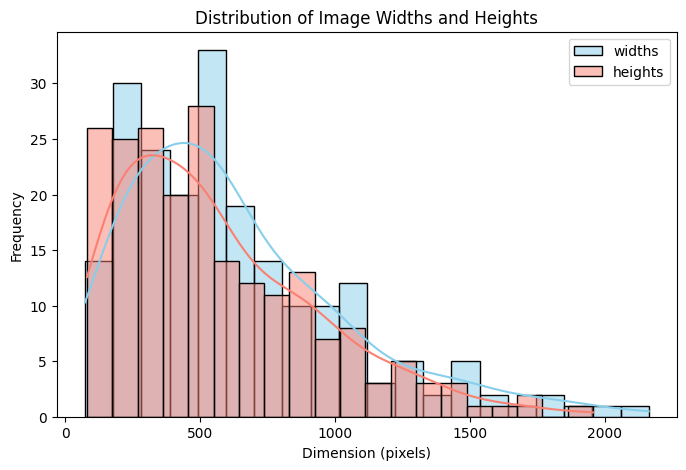

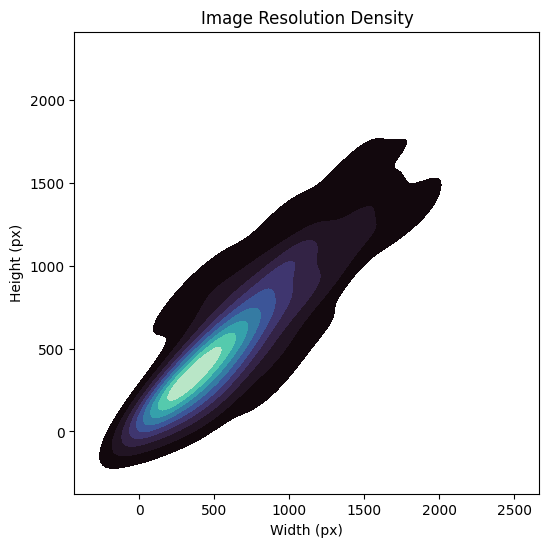


Number of 512×512 images: 10


In [9]:
import matplotlib.pyplot as plt
import seaborn as sns

# Drop missing dimension rows
#valid_dims = train_metadata.dropna(subset=["width", "height"]).copy()
valid_dims = train_metadata.query("format == '.tif'").dropna(subset=['width','height']).copy()

# Compute area (pixels)
valid_dims["area"] = valid_dims["width"] * valid_dims["height"]

# --- 1. Summary table ---
print("Unique resolutions and their counts:")
res_counts = valid_dims.groupby(["width", "height"]).size().reset_index(name="count")
display(res_counts.sort_values("count", ascending=False))

# --- 2. Histogram of image sizes ---
plt.figure(figsize=(8,5))
sns.histplot(valid_dims["width"], bins=20, color="skyblue", label="widths", kde=True)
sns.histplot(valid_dims["height"], bins=20, color="salmon", label="heights", kde=True)
plt.xlabel("Dimension (pixels)")
plt.ylabel("Frequency")
plt.title("Distribution of Image Widths and Heights")
plt.legend()
plt.show()

# --- 3. 2D heatmap of width vs height ---
plt.figure(figsize=(6,6))
sns.kdeplot(data=valid_dims, x="width", y="height", fill=True, cmap="mako")
plt.title("Image Resolution Density")
plt.xlabel("Width (px)")
plt.ylabel("Height (px)")
plt.show()

# --- 4. Optional: show how many 512×512 images, etc. ---
specific_size = (512, 512)
count_512 = ((valid_dims["width"] == specific_size[0]) & (valid_dims["height"] == specific_size[1])).sum()
print(f"\nNumber of {specific_size[0]}×{specific_size[1]} images: {count_512}")


<a id="step5"></a>
## Step 5 — Validate .svs ↔ .tif Consistency

In [7]:
import pandas as pd
from openslide import OpenSlide

def compare_svs_tif_dimensions(root_dir: Path):
    rows = []
    patients = sorted([d for d in root_dir.iterdir() if d.is_dir()])

    for patient_path in patients:
        patient_id = patient_path.name
        svs_files = sorted(patient_path.glob("*.svs"))
        for svs_path in svs_files:
            base = svs_path.stem
            tif_path = patient_path / f"{base}.tif"
            xml_path = patient_path / f"{base}.xml"

            # read svs dims
            svs_w = svs_h = tif_w = tif_h = None
            try:
                with OpenSlide(str(svs_path)) as slide:
                    svs_w, svs_h = slide.dimensions
            except Exception as e:
                print("⚠️ failed to read", svs_path.name, e)

            # read tif dims (fallback to cv2 if OpenSlide fails)
            if tif_path.exists():
                try:
                    with OpenSlide(str(tif_path)) as slide:
                        tif_w, tif_h = slide.dimensions
                except Exception:
                    import cv2
                    img = cv2.imread(str(tif_path))
                    if img is not None:
                        tif_h, tif_w = img.shape[:2]

            rows.append({
                "patient": patient_id,
                "base": base,
                "svs_w": svs_w, "svs_h": svs_h,
                "tif_w": tif_w, "tif_h": tif_h,
                "has_xml": xml_path.exists()
            })

    df = pd.DataFrame(rows)
    df["match"] = (df["svs_w"] == df["tif_w"]) & (df["svs_h"] == df["tif_h"])
    return df

compare_df = compare_svs_tif_dimensions(TRAIN_DIR)
display(compare_df.head())

# --- Summary ---
print("\n✅ Dimension comparison summary:")
print(compare_df["match"].value_counts())
print("\nNon-matching examples (if any):")
display(compare_df[~compare_df["match"]])


,patient,base,svs_w,svs_h,tif_w,tif_h,has_xml,match
0,TCGA-55-1594-01Z-00-DX1,TCGA-55-1594-01Z-00-DX1_001,1024,1024,1024,1024,True,True
1,TCGA-55-1594-01Z-00-DX1,TCGA-55-1594-01Z-00-DX1_002,512,512,512,512,True,True
2,TCGA-55-1594-01Z-00-DX1,TCGA-55-1594-01Z-00-DX1_003,512,512,512,512,True,True
3,TCGA-55-1594-01Z-00-DX1,TCGA-55-1594-01Z-00-DX1_004,512,512,512,512,True,True
4,TCGA-55-1594-01Z-00-DX1,TCGA-55-1594-01Z-00-DX1_005,512,512,512,512,True,True



✅ Dimension comparison summary:
True    209
Name: match, dtype: int64

Non-matching examples (if any):


,patient,base,svs_w,svs_h,tif_w,tif_h,has_xml,match


So, all of them are matching with 40x as expected.

<a id="step6"></a>
## Step 6 — Polygon Area Distribution

Scanning 30 XML files...
Collected 3,485 polygons
min=4.5, median=394.5, mean=481.6, 95th=1099.5


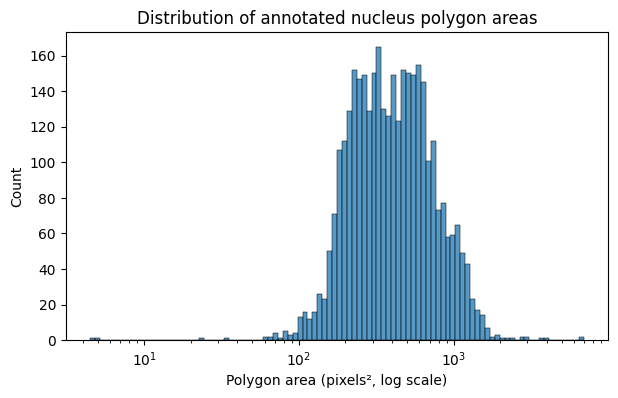

In [10]:
from pathlib import Path
from xml.dom import minidom
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

RAW_ROOT = Path("/projectnb/ec500kb/projects/Fall_2025_Projects/Project_2/AI-guided-whole-slide-imaging-analysis/Datasets/BU_course_data/TrainingData/TrainingImages_and_Annotations")

def collect_polygon_areas(root_dir: Path, max_files=50):
    """Parse up to `max_files` XMLs and record each nucleus polygon area (in pixels)."""
    areas = []
    xml_files = list(root_dir.glob("**/*.xml"))[:max_files]
    print(f"Scanning {len(xml_files)} XML files...")

    for xml_path in xml_files:
        xmldoc = minidom.parse(str(xml_path))
        for reg in xmldoc.getElementsByTagName("Region"):
            vertices = reg.getElementsByTagName("Vertex")
            if len(vertices) < 3:
                continue
            poly = np.array([(float(v.getAttribute("X")), float(v.getAttribute("Y"))) for v in vertices])
            # Shoelace formula for polygon area
            area = 0.5 * np.abs(np.dot(poly[:,0], np.roll(poly[:,1], 1)) - np.dot(poly[:,1], np.roll(poly[:,0], 1)))
            areas.append(area)
    return np.array(areas)

areas = collect_polygon_areas(RAW_ROOT, max_files=30)
print(f"Collected {len(areas):,} polygons")

# --- Summary statistics ---
print(f"min={areas.min():.1f}, median={np.median(areas):.1f}, mean={areas.mean():.1f}, 95th={np.percentile(areas,95):.1f}")

# --- Plot distribution ---
plt.figure(figsize=(7,4))
sns.histplot(areas, bins=100, log_scale=True)
plt.xlabel("Polygon area (pixels², log scale)")
plt.ylabel("Count")
plt.title("Distribution of annotated nucleus polygon areas")
plt.show()


<a id="step7"></a>
## Step 7 — Polygon Areas by Cell Type

Scanning 30 XML files...
Collected 3,485 polygons


,count,mean,50%,min,max
cell_type,,,,,
epithelial,1750.0,647.192286,584.50,114.5,2029.5
lymphocyte,1552.0,256.581508,244.25,5.0,642.5
macrophage,32.0,2032.531250,1531.75,600.0,6920.5
neutrophil,151.0,545.993377,544.00,4.5,1019.0


⚠️ No legend labels found — check if 'cell_type' column is populated.


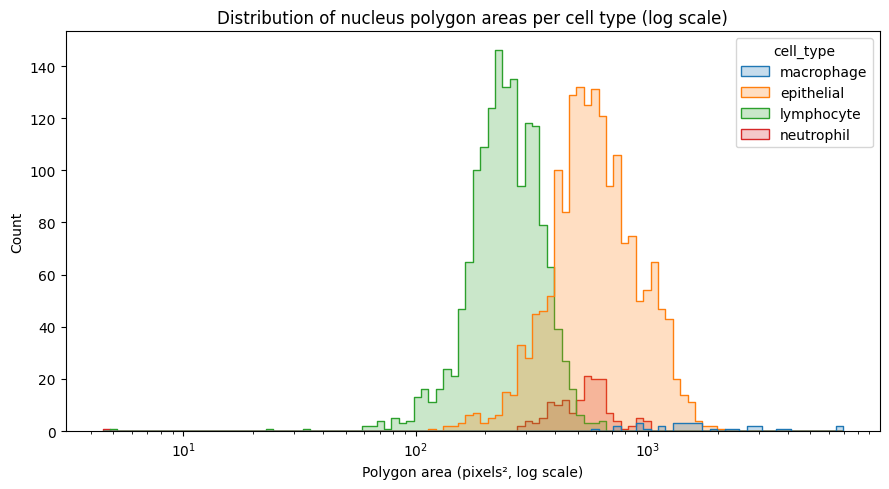

In [12]:
from xml.dom import minidom
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path

RAW_ROOT = Path("/projectnb/ec500kb/projects/Fall_2025_Projects/Project_2/AI-guided-whole-slide-imaging-analysis/Datasets/BU_course_data/TrainingData/TrainingImages_and_Annotations")

def collect_polygon_areas_with_labels(root_dir: Path, max_files=50):
    """Collect polygon areas and associated cell type labels from XML annotations."""
    records = []
    xml_files = list(root_dir.glob("**/*.xml"))[:max_files]
    print(f"Scanning {len(xml_files)} XML files...")

    for xml_path in xml_files:
        xmldoc = minidom.parse(str(xml_path))
        for ann in xmldoc.getElementsByTagName("Annotation"):
            # get cell type label from <Attribute Name="...">
            ann_label = None
            for attr in ann.getElementsByTagName("Attribute"):
                if attr.hasAttribute("Name"):
                    ann_label = attr.getAttribute("Name").strip().lower()
                    break
            if not ann_label:
                continue

            for reg in ann.getElementsByTagName("Region"):
                vertices = reg.getElementsByTagName("Vertex")
                if len(vertices) < 3:
                    continue
                poly = np.array([(float(v.getAttribute("X")), float(v.getAttribute("Y"))) for v in vertices])
                # Shoelace formula for polygon area
                area = 0.5 * np.abs(np.dot(poly[:,0], np.roll(poly[:,1], 1)) - np.dot(poly[:,1], np.roll(poly[:,0], 1)))
                records.append({"cell_type": ann_label, "area": area, "file": xml_path.name})

    return pd.DataFrame(records)

areas_df = collect_polygon_areas_with_labels(RAW_ROOT, max_files=30)
print(f"Collected {len(areas_df):,} polygons")

# --- Clean and summarize ---
areas_df["cell_type"] = areas_df["cell_type"].str.lower().str.strip()
areas_df = areas_df[areas_df["area"] > 0]

summary = areas_df.groupby("cell_type")["area"].describe()[["count", "mean", "50%", "min", "max"]]
display(summary)

# --- Plot: log-scale histograms per cell type ---
plt.figure(figsize=(9,5))
ax = sns.histplot(
    data=areas_df,
    x="area",
    hue="cell_type",
    bins=100,
    log_scale=True,
    element="step",
    common_norm=False,
    palette="tab10"
)
plt.xlabel("Polygon area (pixels², log scale)")
plt.ylabel("Count")
plt.title("Distribution of nucleus polygon areas per cell type (log scale)")

# Fix legend: let seaborn handle it properly
handles, labels = ax.get_legend_handles_labels()
if labels:
    plt.legend(handles=handles, labels=labels, title="Cell Type")
else:
    print("⚠️ No legend labels found — check if 'cell_type' column is populated.")

plt.tight_layout()
plt.show()


<a id="step7"></a>
## Step 7 — Summary (TODO)